In [1]:

##Server
import socket, time, sys , serial
import threading
import pprint
import time
from TCP_server import *
from Serial_ import *
SERIAL_PORT_ROBOT = '/dev/ttyACM0'
SERIAL_PORT_COllECTOR = '/dev/ttyACM1'
SERIAL_RATE = 115200
import threading
from collections import deque

clientCount = 0


buf_broadcast = deque([]) # Queue of message for broadcasting via TCP IP
buf_stm = deque([])

buf_stm


if __name__ == '__main__':
    ser = serial.Serial(SERIAL_PORT_ROBOT, SERIAL_RATE) # Connection to STM32 ROBOT
    #s = server() #create new server listening for connections
    serial_T = serialTread(ser)
    #threading.Thread(target=s.startServer,args=(buf_broadcast,buf_stm,clientCount)).start()#create server thread
    threading.Thread(target=serial_T.run, args=(buf_broadcast,buf_stm)).start()#create serial thread for robot control
    
    time.sleep(1)

#Changer les action_In et action_Out en queue de dictionaire

In [2]:
import numpy as np
import math
import robot as Robot
import Astar as Path_Generator
import Mapping as Map_Generator
import matplotlib.pyplot as plt
from parse import *
%matplotlib inline
def Main_Loop(Set_Objective,robot,mapper):
    path=None
    G=None
    while(not(robot.Has_reached_final_position(Set_Objective))):
        obstacleFront = 0
        print('Get_Map')
        grid = mapper.map()#Get the actual Map
        Get_Pos=robot.get_position()# Get the actual robot Position
        print('Astar Beginning')
        verified_Obj = Path_Generator.validate_objective(Set_Objective,grid, Get_Pos)
        #verified_Obj = Set_Objective
        path, cost , G = Path_Generator.AStarSearch((Get_Pos[0],Get_Pos[1]), (verified_Obj[0],verified_Obj[1]), grid) #Try to find the best path
        checkpoint = Path_Generator.find_vertice(path)#Simplify the path to be straight line
        #new_x,newy,theta_robot = Path_Generator.checkpoint_in_fov(robot,checkpoint)#Try to avoid backward movement unless it is too far back
        #checkpoint = Path_Generator.checkpoint_corrector(checkpoint)#Eliminate again some short path line 
        #print("OLD CHECKPOINT", checkpoint)
        #checkpoint = np.insert(checkpoint,0,[new_x,newy]).reshape((-1,2))# Add repositionning for avoiding backward movement
        #print("NEW CHECKPOINT", checkpoint)
        print('Astar End')

        """Concatenate Displacement Movement"""
        Set_Coordinate=np.zeros((len(checkpoint),4))
        Set_Coordinate[:,0]=checkpoint[:,0]
        Set_Coordinate[:,1]=checkpoint[:,1]
        Set_Coordinate[:,2]=500;
        Set_Coordinate[:,3]=8000;
        """Calculate Optimal Timeout"""
        tempX , tempY, _  = robot.get_position()
        for i in range(len(Set_Coordinate)): 
            time_out_com = math.sqrt( np.float_power(Set_Coordinate[i,0]-tempX , 2) + np.float_power(Set_Coordinate[i,1]-tempY , 2) ) / Set_Coordinate[i,2]
            Set_Coordinate[i,3] = time_out_com*1400 + 1500# 140 %(For incertenties +500 ms(For initial acceleration)
            tempX = Set_Coordinate[i,0]
            tempY = Set_Coordinate[i,1]
        print(Set_Coordinate)
        """Beginning of the loop for each coordinate the robot has to go through"""

        buf_broadcast.clear()#CLear receiving buffer
        Offset_Timeout=1500;#Raspberry timeout for lack of communication 
        Max_Try=2;#Number of try to send that message
        Try =0
        j=0
        while j <len(Set_Coordinate):
            print(j)
            """Get information of one movement"""
            X_Des=Set_Coordinate[j][0]
            Y_Des=Set_Coordinate[j][1]
            Max_Speed=Set_Coordinate[j][2]
            TimeOut=Set_Coordinate[j][3]
            """Create messages"""
            G0_String='G0 X' + str(X_Des)+' Y'+str(Y_Des)+' T'+str(TimeOut)+'\r\n'
            M201_String='M201 H0 S' + str(Max_Speed)+'\r\n'
            M3_String='M3 H3\r\n'
            All_Commands=[G0_String,M201_String,M3_String]
            Finished=0
            Saved_Time=time.time()
            for i in range(0,len(All_Commands)):
                buf_stm.append(All_Commands[i])#Send every messages
            while(Finished==0 and ((time.time()-Saved_Time)<(Set_Coordinate[j][3]+Offset_Timeout)/1000)) :
                #No "M0" message from the STM32 and still on time according to the Raspi
                if(buf_broadcast):
                    received=buf_broadcast.popleft()
                    print(received)
                    str2=parse("M{} X{} Y{} A{} T{} S{}",received)
                    if(str2 is not None):
                        array_argument=np.zeros(6)
                        for i in range(0,6):
                            array_argument[i]=float(str2[i])
                        if (array_argument[0]==0):
                            robot.set_position(array_argument[1],array_argument[2],array_argument[3])
                            if array_argument[4]==0: #T0 argument Arrived or sensor
                                Finished=1#M0 has been received, do the next command
                                print('Finished')
                            else:
                                Finished=1
                                print('Timeout')
                            feedback_sensors = int(array_argument[5])# feedback sensor MLKJIHGFEDCBA 
                            mapper.new_obstacle(robot.sensor_state(feedback_sensors))
                        else:
                            print('Not M0 Frame',array_argument[0])
                    else:#Not an M0 frame 
                        pass
            if(Finished==0 and Try<Max_Try):
                print('Lack of answer from STM32, Try Number '+str(Try+1))
                Try=Try+1
            else:
                j=j+1
                Try =0
            """End of try for one coordinate"""

        print('End of total movement')    
    return path, G

In [3]:
buf_stm.append("G92 X0 Y0 A0\r\n") 
print('Position Set')
robot = Robot.robot(0,0,0)

print('Robot objet Set')
mapper = Map_Generator.Mapping()

Position Set
Robot objet Set


In [ ]:


print('Map objet Set')
Set_Objective=[[1250,0],[1250,1250],[0,1250],[0,0]]
print('Main_Loop')
for i in range(16):
    for e in Set_Objective:
        path_,G_=Main_Loop(e,robot,mapper)
mapper.display(G_,path_,robot);


Map objet Set
Main_Loop
Get_Map
Astar Beginning
Astar End
[[1250.    0.  500. 5000.]]
0
OK: X=1250.00 Y=0.00 A=0.00 T=5000.00

OK: D_Profil S=500 A=50 B=100 

OK: M3 H3 S15

M0 X1217.90 Y-1.25 A1.40 T1 S0

Timeout
{'a': 0, 'i': 0, 'c': 0, 'g': 0, 'f': 0, 'j': 0, 'd': 0, 'h': 0, 'b': 0, 'e': 0, 'l': 0, 'k': 0, 'm': 0}
End of total movement
Get_Map
Astar Beginning
Astar End
[[1250.           30.          500.         1618.79393924]
 [1250.         1250.          500.         4916.        ]]
0
OK: X=1250.00 Y=30.00 A=0.00 T=1618.79

OK: D_Profil S=500 A=50 B=100 

OK: M3 H3 S15

M0 X1239.66 Y12.10 A56.66 T0 S0

Finished
{'a': 0, 'i': 0, 'c': 0, 'g': 0, 'f': 0, 'j': 0, 'd': 0, 'h': 0, 'b': 0, 'e': 0, 'l': 0, 'k': 0, 'm': 0}
1
OK: X=1250.00 Y=1250.00 A=0.00 T=4916.00

OK: D_Profil S=500 A=50 B=100 

OK: M3 H3 S15

M0 X1254.13 Y1215.30 A96.18 T1 S0

Timeout
{'a': 0, 'i': 0, 'c': 0, 'g': 0, 'f': 0, 'j': 0, 'd': 0, 'h': 0, 'b': 0, 'e': 0, 'l': 0, 'k': 0, 'm': 0}
End of total movement
Get_Map
A

In [1]:
#Set_Objective=[[2000,0]]
#path, G=Main_Loop(Set_Objective[0],robot,mapper)
mapper.display(G_,path_,robot);

NameError: name 'mapper' is not defined

In [ ]:
#M0 X1401.47 Y329.98 A-40.82 T1 S0
mapper.display(G,path,robot)
path, cost , G = Path_Generator.AStarSearch((Get_Pos[0],Get_Pos[1]), (Set_Objective[0][0],Set_Objective[0][1]), grid) #Try to find the best path
plt.imshow(grid,origin='lower')

In [5]:
buf_stm.append("G0 X1000 T5000\r\n")#Send every messages

buf_stm.append("M3 H3\r\n")#Send every messages
buf_broadcast

deque(['M0 X963.52 Y233.70 A29.42 T1 S0\r\n'])

In [1]:
mapper.display(G,path,robot);

NameError: name 'mapper' is not defined

In [ ]:
Map_Rewards is a map of rewards(aka bottle or special zone according to the time of the game)
Map_terrain is a map of obstacle and wall 

while(running)
    if(Robot_has_reached_final_position)
        Get_Interresting_Position_To_Go();
    Set_Of_Coordinate=Calculate_Path(Actual_Pos,Position_To_Go,Map_terrain)
    for i in Set_Of_Coordinate
    #From here 
        Send set_of_Coordinate[i]
        Wait_for_answer
        Get_Position of the robot and state
        Actual_Pos=Correlation(Beacon,Robot_Pos)
        if State==Blocked
            Add_To_Map(Actual_Pos,Sensor_Trigged)
            break for loop
        else if State== Finished_Action
            continue
    #to here the robot can move
    Bottle_detection_behavior(Actual_Pos,Map_Rewards)

(-1800.0, 600.0, 1.9505293088565114)
{'h': 0, 'd': 0, 'k': 0, 'l': 0, 'b': 0, 'g': 0, 'f': 0, 'j': 0, 'e': 0, 'i': 0, 'c': 0, 'a': 1, 'm': 0}
NEW OBSATCLE
NEW OBSATCLE
object [3000, 1600]
grid_value 255
310 170
290 170
310 150
330 190


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

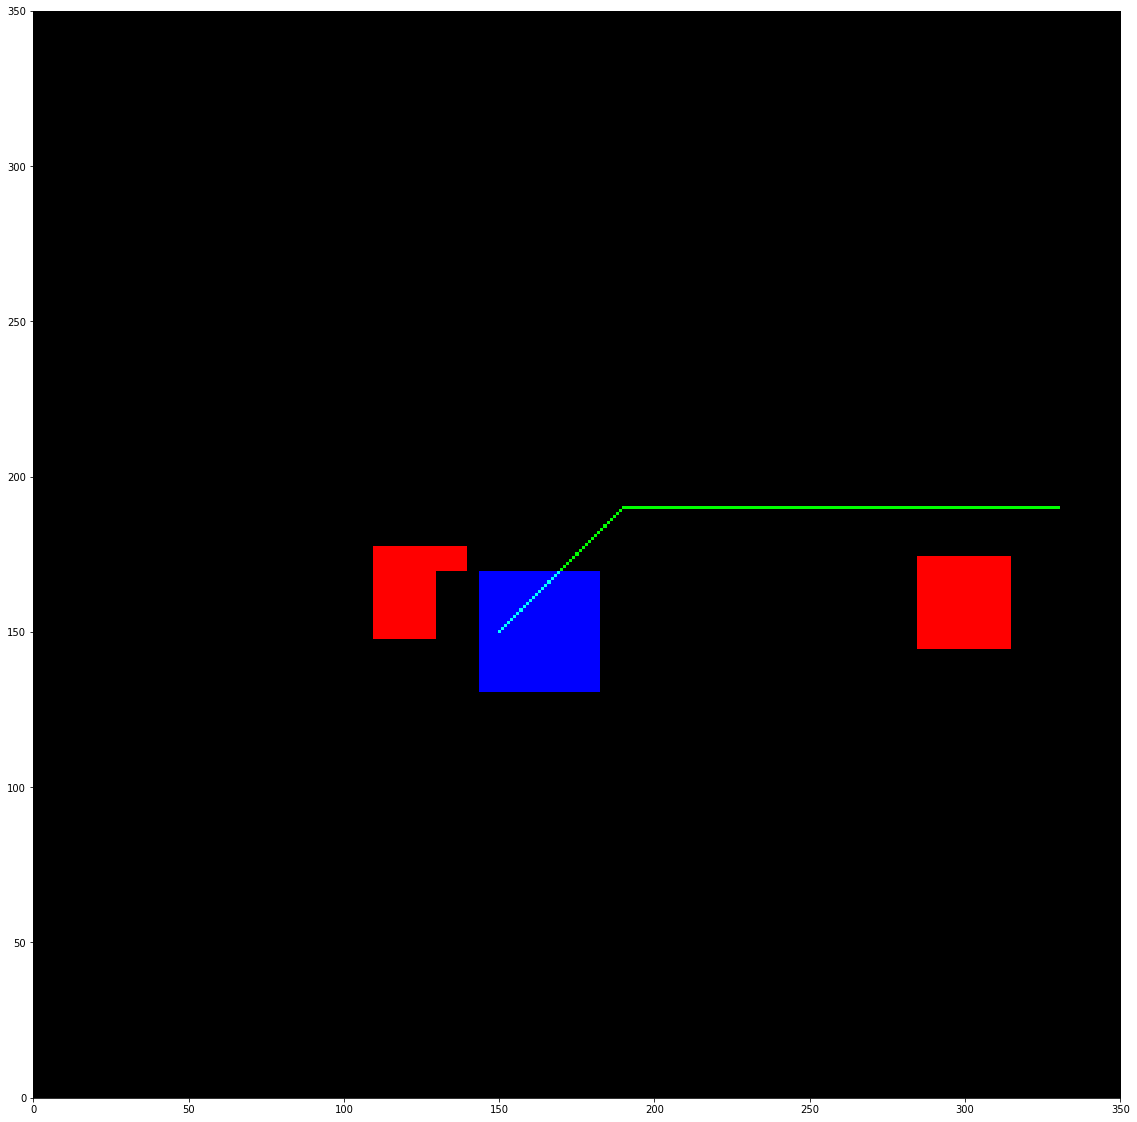

In [1]:
import robot as Robot
import Astar as Path_Generator
import Mapping as Map_Generator
import numpy as np
import matplotlib.pyplot as plt
from parse import *
%matplotlib inline
robot = Robot.robot(1500,1500,0)

print(robot.get_beacon_position())
#print(robot.sensor_state(2048+16))
mapper = Map_Generator.Mapping()
grid_updated=mapper.map()
XY = robot.sensor_state(1)
#XY = robot.sensor_state(1+2+4096)
mapper.new_obstacle(XY)

mapper.new_obstacle([[300,160]])
grid_updated=mapper.map()
objective = [3000,1600]

print("object",objective)
print("grid_value",grid_updated[round(objective[1]/10),round(objective[0]/10)])
valid_objective = Path_Generator.validate_objective(objective,grid_updated, robot.get_position())
path, cost , G = Path_Generator.AStarSearch((1500,1500), (valid_objective[0],valid_objective[1]), grid_updated)#Try to find the best path
checkpoint = Path_Generator.find_vertice(path)#Simplify the path to be straight line
new_x,newy,theta_robot = Path_Generator.checkpoint_in_fov(robot,checkpoint)
mapper.display(G,path,robot)


In [1]:
checkpoint

NameError: name 'checkpoint' is not defined

In [12]:
new_x,newy,theta_robot

(1500, 1500, 3.141592653589793)

2
